In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [34]:
import pprint
import glob
from pathlib import Path

from tqdm.autonotebook import tqdm
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import utils

In [52]:
# this notebook recursively finds all .objs in the input mesh folder and renders them into the output render folder, as jpgs with white backgrounds
#INPUT_MESH_DIR = "data/test_dataset"
#OUTPUT_RENDER_DIR = "data/semantic_dis/fake_renders"

INPUT_MESH_DIR = "data/misc/example_shapenet"
OUTPUT_RENDER_DIR = "data/semantic_dis/real_renders"

# render settings
silhouette = True
img_size = 224
device = torch.device("cuda:0")
batch_size = 8
num_azims = 8
# 0.,  45.,  90., 135., 180., 225., 270., 315.
azims = torch.linspace(0, 360, num_azims+1)[:-1]
elevs = torch.ones(num_azims) * 25
dists = torch.ones(num_azims) * 1.7


data/misc/example_shapenet/03001627/1b938d400e1a340b17b431cae0dd70ed/model.obj
03001627_1b938d400e1a340b17b431cae0dd70ed_model


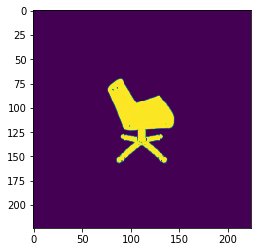

03001627_1b938d400e1a340b17b431cae0dd70ed_model


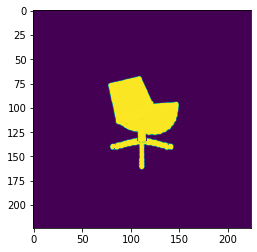

03001627_1b938d400e1a340b17b431cae0dd70ed_model


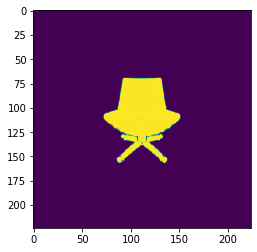

03001627_1b938d400e1a340b17b431cae0dd70ed_model


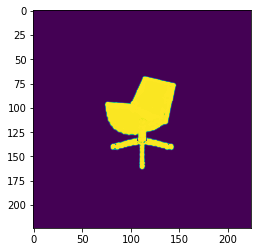

03001627_1b938d400e1a340b17b431cae0dd70ed_model


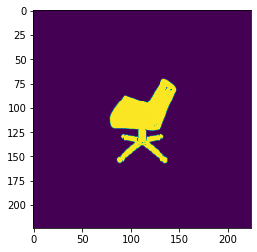

03001627_1b938d400e1a340b17b431cae0dd70ed_model


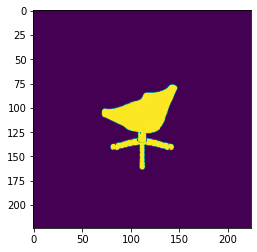

03001627_1b938d400e1a340b17b431cae0dd70ed_model


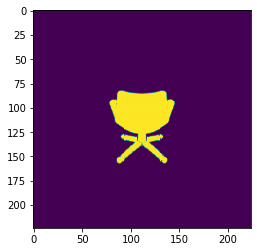

03001627_1b938d400e1a340b17b431cae0dd70ed_model


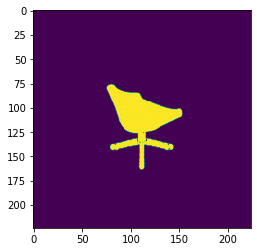

In [53]:
if not os.path.exists(OUTPUT_RENDER_DIR):
    os.makedirs(OUTPUT_RENDER_DIR)
obj_paths = list(Path(INPUT_MESH_DIR).rglob('*.obj'))

with tqdm(total=len(obj_paths)*num_azims) as pbar:
    for model_path in obj_paths:
        print(model_path)
        with torch.no_grad():
            mesh = utils.load_untextured_mesh(model_path, device)
            renders = utils.batched_render(mesh, azims, elevs, dists, batch_size, device, silhouette, img_size)
            for i, render in enumerate(renders):
                if silhouette:
                    img_render = (render[ ..., 3].cpu().numpy() * 255).astype(int)
                else:
                    img_render = (render[ ..., :3].cpu().numpy()* 255).astype(int) 

                model_name = str(model_path).replace(INPUT_MESH_DIR,'').replace('/','_').replace(".obj","")
                if model_name[0] == '_': model_name = model_name[1:]
                print(model_name)
                cv2.imwrite(os.path.join(OUTPUT_RENDER_DIR, "{}_{}.jpg".format(model_name, i)), img_render)
                pbar.update(1)
                plt.imshow(img_render)
                plt.show()

            break

In [ ]:
# TODO: randomize size?